In [12]:
import os
import pandas as pd
import numpy as np
import json
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models import resnet50
import torch.nn as nn
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [13]:

def prepare_data(dataset_folder):
    train_csv_path = os.path.join(dataset_folder, 'train.csv')
    train_images_path = os.path.join(dataset_folder, 'train')
    label_descriptions_path = os.path.join(dataset_folder, 'label_descriptions.json')

    if not os.path.exists(train_csv_path):
        raise FileNotFoundError(f"Train CSV file not found: {train_csv_path}")
    if not os.path.exists(train_images_path):
        raise FileNotFoundError(f"Train images folder not found: {train_images_path}")
    if not os.path.exists(label_descriptions_path):
        raise FileNotFoundError(f"Label descriptions file not found: {label_descriptions_path}")

    df = pd.read_csv(train_csv_path)
    
    # Remove duplicates based on 'ImageId'
    df = df.drop_duplicates(subset='ImageId')
    
    # Ensure we're creating the 'image_path' column
    df['image_path'] = df['ImageId'].apply(lambda x: os.path.join(train_images_path, x))
    
    # Verify that at least one image file exists
    sample_image_path = df['image_path'].iloc[0]
    if not os.path.exists(sample_image_path):
        raise FileNotFoundError(f"No image file found at {sample_image_path}. Please check the file naming convention.")

    with open(label_descriptions_path, 'r') as f:
        label_descriptions = json.load(f)

    print("Data preparation complete. Sample data:")
    print(df.head())
    print("\nColumns in DataFrame:")
    print(df.columns)
    print("\nLabel descriptions sample:")
    print(list(label_descriptions.items())[:5])

    return df, label_descriptions

In [14]:
def load_segmentation_model():
    model = deeplabv3_resnet101(pretrained=True)
    model.eval()
    print("Segmentation model loaded successfully.")
    return model

In [15]:
def segment_image(model, image_path):
    transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    
    segmentation_mask = output.argmax(0).byte().cpu().numpy()
    print(f"Image segmented. Unique labels: {np.unique(segmentation_mask)}")
    return segmentation_mask

In [16]:
def load_feature_extractor():
    model = resnet50(pretrained=True)
    model = nn.Sequential(*list(model.children())[:-1])
    model.eval()
    print("Feature extractor loaded successfully.")
    return model

In [17]:
def extract_features(model, image_path):
    transform = T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)
    
    with torch.no_grad():
        features = model(input_tensor)
    
    features = features.squeeze().cpu().numpy()
    print(f"Features extracted. Shape: {features.shape}")
    return features

In [18]:
def calculate_similarity(input_features, dataset_features):
    similarities = cosine_similarity(input_features.reshape(1, -1), dataset_features)[0]
    print(f"Similarities calculated. Shape: {similarities.shape}")
    return similarities

In [19]:
def display_images(image_paths, titles):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))
    for i, (img_path, title) in enumerate(zip(image_paths, titles)):
        img = Image.open(img_path)
        if len(image_paths) == 1:
            axes.imshow(img)
            axes.set_title(title)
            axes.axis('off')
        else:
            axes[i].imshow(img)
            axes[i].set_title(title)
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

In [20]:
def get_recommendations(df, similarities, input_image_id, top_n=5):
    temp_df = df.iloc[:len(similarities)].copy()
    temp_df['similarity'] = similarities
    
    # Exclude the input image
    temp_df = temp_df[temp_df['ImageId'] != input_image_id]
    
    # Sort by similarity and keep only the first occurrence of each image
    recommendations = temp_df.sort_values('similarity', ascending=False).drop_duplicates('ImageId').head(top_n)
    
    print("Top recommendations:")
    print(recommendations[['ImageId', 'similarity']])
    
    # Check if 'image_path' column exists, if not use 'ImageId'
    if 'image_path' in recommendations.columns:
        return recommendations[['ImageId', 'similarity', 'image_path']]
    else:
        print("Warning: 'image_path' column not found. Using 'ImageId' instead.")
        return recommendations[['ImageId', 'similarity']]

In [21]:
def process_user_upload(upload_path, df_subset, segmentation_model, feature_extractor, dataset_features):
    print(f"Processing user upload: {upload_path}")
    
    input_image_id = os.path.basename(upload_path)

    segmentation_mask = segment_image(segmentation_model, upload_path)
    
    input_features = extract_features(feature_extractor, upload_path)
    
    similarities = calculate_similarity(input_features, dataset_features)
    
    recommendations = get_recommendations(df_subset, similarities, input_image_id)
    
    if 'image_path' in recommendations.columns:
        image_paths = [upload_path] + recommendations['image_path'].tolist()
    else:
        image_paths = [upload_path] + [os.path.join(os.path.dirname(upload_path), id) for id in recommendations['ImageId']]

    image_paths = list(dict.fromkeys(image_paths))
    
    titles = ['Input'] + [f"Sim: {sim:.2f}" for sim in recommendations['similarity']]
    display_images(image_paths, titles)
    
    return recommendations

Data preparation complete. Sample data:
                                 ImageId  \
0   00000663ed1ff0c4e0132b9b9ac53f6e.jpg   
9   0000fe7c9191fba733c8a69cfaf962b7.jpg   
11  0002ec21ddb8477e98b2cbb87ea2e269.jpg   
15  0002f5a0ebc162ecfb73e2c91e3b8f62.jpg   
18  0004467156e47b0eb6de4aa6479cbd15.jpg   

                                        EncodedPixels  Height  Width ClassId  \
0   6068157 7 6073371 20 6078584 34 6083797 48 608...    5214   3676       6   
9   2201176 1 2203623 3 2206071 5 2208518 8 221096...    2448   2448      33   
11  2673735 2 2676734 8 2679734 13 2682733 19 2685...    3000   1997      33   
15  435 132 1002 132 1569 132 2136 132 2703 132 32...     567    400      10   
18  132663 8 133396 25 134130 41 134868 53 135611 ...     750    500      10   

                                           image_path  
0   myntra-dataset\train\00000663ed1ff0c4e0132b9b9...  
9   myntra-dataset\train\0000fe7c9191fba733c8a69cf...  
11  myntra-dataset\train\0002ec21ddb8477e98b2c

c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Segmentation model loaded successfully.


c:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Feature extractor loaded successfully.
Extracting features for 1000 images in the dataset...
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048,)
Features extracted. Shape: (2048

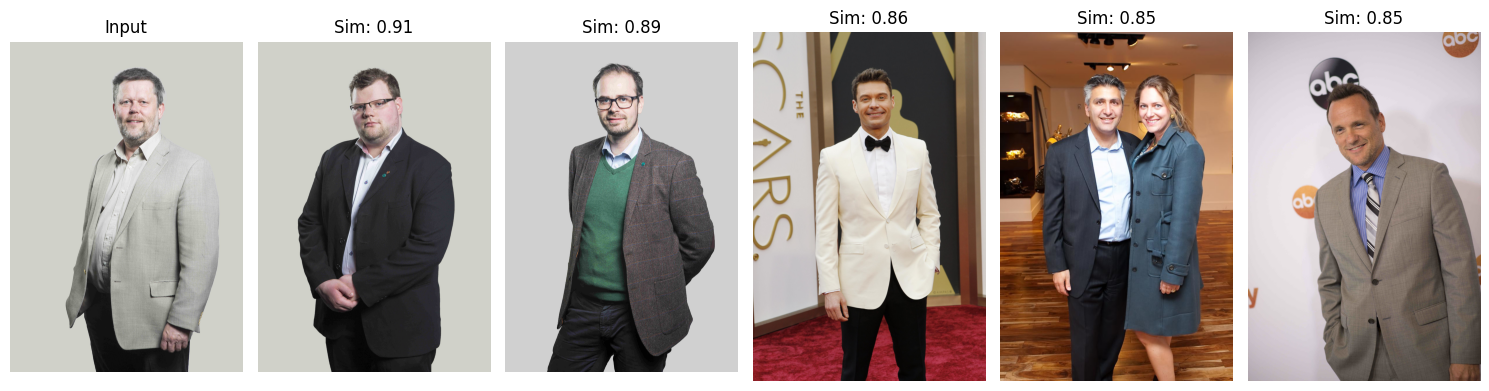

In [22]:
def main():
    # Define the path to your dataset folder
    dataset_folder = r'myntra-dataset'
    
    # Load and prepare data
    df, label_descriptions = prepare_data(dataset_folder)
    
    # Load models
    segmentation_model = load_segmentation_model()
    feature_extractor = load_feature_extractor()
    
    # Limit the number of images to process
    num_images_to_process = 1000  # You can adjust this number
    df_subset = df.head(num_images_to_process)
    
    # Extract features for the subset of images in the dataset
    print(f"Extracting features for {num_images_to_process} images in the dataset...")
    dataset_features = []
    for image_path in df_subset['image_path' if 'image_path' in df_subset.columns else 'ImageId']:
        features = extract_features(feature_extractor, image_path)
        dataset_features.append(features)
    dataset_features = np.array(dataset_features)
    print(f"Dataset features extracted. Shape: {dataset_features.shape}")
    
    # Example usage
    user_upload = os.path.join(dataset_folder, 'train', '00000663ed1ff0c4e0132b9b9ac53f6e.jpg')
    recommendations = process_user_upload(user_upload, df_subset, segmentation_model, feature_extractor, dataset_features)

if __name__ == "__main__":
    main()